<h4>Introduction to Neural Network Regression with TensorFlow</h4>

In [1]:
import tensorflow as tf
import ta
import numpy as np
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats

print("tf.__version__")


class Forex(object):
    def __init__(self, ticker: str, time_frame: str):
        self.ticker = ticker
        self.time_frame = time_frame

    def load_data(ticker: str, time_frame: str):  # Load dataset.
        params_dic = {
            'host': 'localhost',
            'database': '/home/felipe/Desktop/python/projects/algorithmic-trading/data/forex.db'
        }
        with sqlite3.connect(f"{params_dic['database']}") as connection:
            dataset = pd.read_sql_query(
                "SELECT * FROM "+ticker.lower()+"_"+time_frame, connection)
            return dataset


class FeatureEngineering(Forex):
    def __init__(self, ticker: str, time_frame: str):
        super().__init__(ticker, time_frame)

    def load_features(self):  # Load features
        dataset = Forex.load_data(self.ticker, self.time_frame)
        dataset.index = dataset['date']
        CCI = ta.trend.CCIIndicator(
            high=dataset['high'], low=dataset['low'], close=dataset['close'], window=21)  # Initialize CCI
        WMA = ta.trend.WMAIndicator(
            close=dataset['close'], window=21, fillna=False)  # Initialize VMA
        RSI = ta.momentum.RSIIndicator(
            close=dataset['close'], window=21, fillna=False)  # Initialize RSI
        STOCH = ta.momentum.StochasticOscillator(
            close=dataset['close'], high=dataset['high'], low=dataset['low'], window=21, smooth_window=3, fillna=False)
        DonchianChannel = ta.volatility.DonchianChannel(
            high=dataset['high'], low=dataset['low'], close=dataset['close'], window=21, fillna=False)
        dataset['EMA8'] = dataset['close'].ewm(span=8, adjust=False).mean()
        dataset['EMA21'] = dataset['close'].ewm(span=21, adjust=False).mean()
        dataset['STOCH'] = STOCH.stoch()  # (STOCH) - Momentum
        dataset['RSI'] = RSI.rsi()  # (RSI) - Momentum
        dataset['CCI'] = CCI.cci()  # (CCI) - Trend
        dataset['WMA'] = WMA.wma()  # (VMA) - Trend
        # DonchianChannel - Volatility
        dataset['Donchian'] = DonchianChannel.donchian_channel_mband()
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['weekday'] = datetime.datetime.today().weekday()
        dataset['normalize'] = dataset['close'] / dataset['close'].iloc[0]
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['day'] = dataset['date'].dt.day
        dataset['day_of_year'] = dataset['date'].dt.dayofyear
        dataset['weekday'] = dataset['date'].apply(
            lambda x: x.weekday())  # Monday = 0 / Friday = 4
        dataset['month'] = dataset['date'].dt.month
        dataset['min_21'] = dataset['close'].rolling(window=21).min()
        dataset['max_21'] = dataset['close'].rolling(window=21).max()
        dataset['std_21'] = dataset['close'].rolling(window=21).std()
        dataset['sma_21'] = dataset['close'].rolling(window=21).mean()
        dataset['ema_21'] = dataset['close'].ewm(com=21, min_periods=21).mean()
        dataset['zscore'] = stats.zscore(dataset['close'])
        for lag in range(1, 4):
            dataset[f'daily_return_{lag}'] = dataset['close'].pct_change(lag)
        for i in range(1, 4):
            dataset[f'difference_{i}'] = dataset['close'].diff(i)
        for i in range(1, 4):
            dataset[f'daily change%_{i}'] = (
                (dataset['close'] / dataset['close'].shift(i)) * 100 - 100)
        dataset['positive/negative'] = np.where(
            dataset['daily_return_1'] > 0, 1, 0)
        return pd.DataFrame(dataset.dropna())


currency_pair = ['AUDCAD']
#currency_pair = ['AUDCAD', 'AUDNZD', 'AUDUSD', 'CADCHF', 'EURAUD', 'EURBRL', 'EURCAD', 'EURCHF', 'EURHUF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'GBPNZD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDMXN', 'USDSGD', 'USDTRY', 'NZDCAD', 'NZDUSD', 'NZDJPY']
for currency in currency_pair:
    # time_frames = ['1d', '1wk', '1mo', '3mo'] # Intervals: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
    time_frames = ['1d']
    for time_frame in time_frames:
        dataset = FeatureEngineering(currency, time_frame).load_features()


print(dataset.info())
dataset.tail()


2022-04-22 11:34:00.617494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 11:34:00.617516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf.__version__
<class 'pandas.core.frame.DataFrame'>
Index: 4767 entries, 2003-12-29 00:00:00 to 2022-04-16 00:00:00
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               4767 non-null   datetime64[ns]
 1   open               4767 non-null   float64       
 2   high               4767 non-null   float64       
 3   low                4767 non-null   float64       
 4   close              4767 non-null   float64       
 5   EMA8               4767 non-null   float64       
 6   EMA21              4767 non-null   float64       
 7   STOCH              4767 non-null   float64       
 8   RSI                4767 non-null   float64       
 9   CCI                4767 non-null   float64       
 10  WMA                4767 non-null   float64       
 11  Donchian           4767 non-null   float64       
 12  weekday            4767 non-null   int64         
 13  normalize          4

,date,open,high,low,close,EMA8,EMA21,STOCH,RSI,CCI,...,daily_return_1,daily_return_2,daily_return_3,difference_1,difference_2,difference_3,daily change%_1,daily change%_2,daily change%_3,positive/negative
date,,,,,,,,,,,,,,,,,,,,,
2022-04-12 00:00:00,2022-04-12,0.937261,0.944476,0.936295,0.937261,0.939318,0.936473,58.585451,54.241774,40.568193,...,0.000739,-0.004450,-0.005917,0.000692,-0.004189,-0.005579,0.073888,-0.444953,-0.591722,1
2022-04-13 00:00:00,2022-04-13,0.941400,0.942997,0.934900,0.941400,0.939781,0.936921,70.606952,56.640289,42.745676,...,0.004416,0.005158,-0.000053,0.004139,0.004831,-0.000050,0.441607,0.515821,-0.005312,1
2022-04-14 00:00:00,2022-04-14,0.936320,0.937684,0.932300,0.936320,0.939012,0.936866,55.852434,53.056306,-41.404092,...,-0.005396,-0.001004,-0.000266,-0.005080,-0.000941,-0.000249,-0.539620,-0.100397,-0.026583,0
2022-04-15 00:00:00,2022-04-15,0.934089,0.934770,0.931900,0.934089,0.937918,0.936614,22.939861,51.552078,-111.764860,...,-0.002383,-0.007766,-0.003384,-0.002231,-0.007311,-0.003172,-0.238273,-0.776608,-0.338431,0
2022-04-16 00:00:00,2022-04-16,0.931760,0.931760,0.931760,0.931760,0.936549,0.936172,12.643708,49.998299,-151.662858,...,-0.002493,-0.004870,-0.010240,-0.002329,-0.004560,-0.009640,-0.249333,-0.487012,-1.024005,0


<h4>Create Neural Network - Regression</h6>
<ul>
    <li>Create a model (define the input and output layers, hidden layers, neurons per hidden layer)</li>
    <li>Compile a model (define the loss function, output activation and loss function, optimizer and evaluate the metrics)</li>
    <li>Fitting a model</li>
</ul>

(4767, 1) <class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'float16'> 

(4767, 1) <class 'tensorflow.python.framework.ops.EagerTensor'> <dtype: 'float16'> 

x_train: (3813, 1), y_train:(3813, 1), <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float16'> 

x_test: (954, 1), y_test:(954, 1), <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float16'> 

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 100)               200       
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 output_layer (Dense)        (None, 1)                 11    

2022-04-22 11:34:04.487321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-22 11:34:04.487352: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-22 11:34:04.487368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felipe-Inspiron-3501): /proc/driver/nvidia/version does not exist
2022-04-22 11:34:04.488868: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/felipe/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: T

Epoch 1/10
120/120 [==============================] - 1s 1ms/step - loss: 0.0039 - mean_absolute_error: 0.0039 - mse: 3.2498e-05
Epoch 2/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.1799e-05
Epoch 3/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.1440e-05
Epoch 4/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.1277e-05
Epoch 5/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.0734e-05
Epoch 6/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.0785e-05
Epoch 7/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - mse: 3.0807e-05
Epoch 8/10
120/120 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_

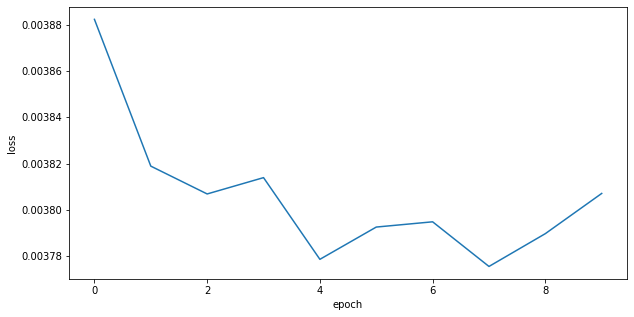

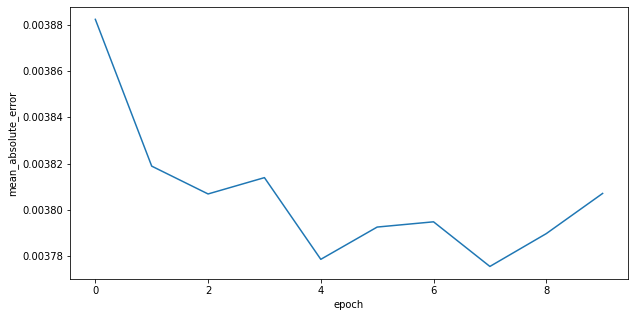

Y Prediction Model: [[ 1.7033e-03]
 [-4.8220e-05]
 [-3.1338e-03]
 [-1.4429e-03]
 [-3.0303e-04]
 [ 4.3869e-04]
 [-4.1962e-03]
 [-3.4733e-03]
 [-3.5572e-03]
 [ 5.6028e-04]
 [ 1.3380e-03]
 [ 3.3264e-03]
 [ 9.9182e-04]
 [-3.3798e-03]
 [-4.2114e-03]
 [-5.9853e-03]
 [-2.0409e-03]
 [-1.4579e-04]
 [ 1.3323e-03]
 [ 9.1124e-04]
 [ 1.1797e-03]
 [ 2.3174e-03]
 [ 2.4929e-03]
 [ 1.1768e-03]
 [ 7.1859e-04]
 [-3.4738e-04]
 [ 2.3918e-03]
 [ 2.7847e-04]
 [-3.8147e-03]
 [-7.0953e-03]
 [-6.2904e-03]
 [-4.8485e-03]
 [-3.8052e-03]
 [-3.2558e-03]
 [ 1.0014e-03]
 [ 2.1114e-03]
 [ 3.2902e-03]
 [ 4.6577e-03]
 [ 2.2087e-03]
 [ 2.1305e-03]
 [-1.9455e-03]
 [ 4.5276e-04]
 [ 5.6982e-04]
 [ 3.2692e-03]
 [ 3.1257e-04]
 [ 2.9147e-05]
 [-3.7727e-03]
 [-3.0541e-04]
 [ 9.6321e-04]
 [ 2.4490e-03]
 [ 2.2659e-03]
 [ 1.1501e-03]
 [ 5.7678e-03]
 [ 4.2763e-03]
 [ 4.8904e-03]
 [ 2.5444e-03]
 [ 4.2763e-03]
 [ 3.6106e-03]
 [ 1.5087e-03]
 [-1.5116e-03]
 [ 6.9094e-04]
 [ 1.8902e-03]
 [ 2.7027e-03]
 [ 2.1915e-03]
 [ 1.2445e-03]
 [ 1.

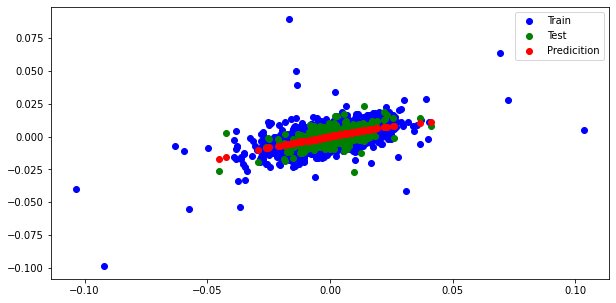

30/30 [==============================] - 0s 894us/step - loss: 0.0028 - mean_absolute_error: 0.0028 - mse: 1.4808e-05
MAE: [9.0027e-04 5.6419e-03 2.3708e-03 8.5907e-03 2.5749e-03 4.0588e-03
 2.3155e-03 3.5152e-03 6.9618e-04 4.6043e-03 9.0885e-04 1.1806e-03
 3.2291e-03 5.9052e-03 2.6970e-03 1.2932e-03 5.1651e-03 3.4409e-03
 4.6158e-03 1.0109e-03 2.8801e-03 1.9016e-03 9.9182e-05 1.5068e-03
 1.6022e-03 1.7691e-04 5.3635e-03 7.6141e-03 8.5449e-03 5.3368e-03
 1.4076e-03 3.2616e-03 4.7913e-03 1.4086e-03 2.0428e-03 2.3632e-03
 1.3552e-03 2.4605e-03 5.2338e-03 4.6635e-04 2.1324e-03 2.6245e-03
 1.4057e-03 1.0719e-03 6.3210e-03 1.2121e-03 3.3875e-03 4.9744e-03
 3.6411e-03 4.8065e-03 1.7014e-03 1.5068e-04 6.2866e-03 4.9210e-03
 2.0256e-03 2.4796e-03 1.8692e-04 2.7313e-03 3.1948e-03 1.9608e-03
 5.7945e-03 4.4823e-05 3.3493e-03 2.4662e-03 2.3766e-03 1.9836e-03
 7.6199e-04 2.9907e-03 2.2106e-03 1.8425e-03 1.9054e-03 4.0398e-03
 2.5654e-03 2.2888e-04 7.3853e-03 2.0218e-03 3.6240e-04 1.7796e-03
 6.328

In [2]:
# Create a feature
x = tf.constant(dataset.loc[:, dataset.columns.isin(['daily_return_3'])], dtype=tf.float16)
#x = tf.constant(dataset.loc[:, ~dataset.columns.isin(['date', 'daily_return_1'])], dtype=tf.float16)
print(x.shape, type(x), x.dtype, '\n')

# Create a label
y = tf.constant(dataset.loc[:, dataset.columns.isin(['daily_return_1'])], dtype=tf.float16)
print(y.shape, type(y), y.dtype, '\n')

# Split train and test (3 Sets)
percent_index = int(0.80 * len(x))
x_train, x_test = tf.constant(x[:percent_index], dtype=tf.float16), tf.constant(x[percent_index:], dtype=tf.float16)
y_train, y_test = tf.constant(y[:percent_index], dtype=tf.float16), tf.constant(y[percent_index:], dtype=tf.float16)
print(f'x_train: {x_train.shape}, y_train:{y_train.shape}, {type(y_train)}, {y_train.dtype} \n')
print(f'x_test: {x_test.shape}, y_test:{y_test.shape}, {type(y_test)}, {y_test.dtype} \n')
#print(x_test, '\n')

# Create a model (define the input and output layers, hidden layers, neurons per hidden layer)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(x_train.shape[1],), name='input_layer'),  # input layer
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, name='output_layer') # output layer
], name='Model')

# Compile a model (define the loss function, output activation and loss function, optimizer and evaluate the metrics.)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.mae, metrics=['mean_absolute_error', 'mse'])
print(f'Summary:\n {model.summary()} \n')

# Fit the model
history = model.fit(x_train, y_train, epochs=10)

# Visualize Metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'])
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.show()

# Predict using model and x_test
y_prediction = tf.constant(model.predict(x_test), dtype=tf.float16)
#y_prediction = tf.squeeze(y_prediction)
print(f'Y Prediction Model: {y_prediction} \n')
#print(f'y_prediction: {y_prediction.shape}, {type(y_prediction)}', '\n')

# Predict using model and last parameters ('daily_return_2' to discover 'daily_return_1')
print(dataset['daily_return_3'][-1])
y_prediction_personal = model.predict([[dataset['daily_return_3'][-1]]])
print(f'Y Prediction Parameter Personal: {y_prediction_personal} \n')

# Predict using model ('daily_return_2', 'daily_return_3' to discover 'daily_return_1')
def plot_prediction(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, y_prediction=y_prediction):
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train, y_train, c='b', label='Train')
    plt.scatter(x_test, y_test, c='g', label='Test')
    plt.scatter(x_test, y_prediction, c='r', label='Predicition')
    plt.legend()
    plt.show()
plot_prediction()

# Model_evaluate
model.evaluate(x_test, y_test)

# Mean Absolute Error
mae = tf.metrics.mean_absolute_error(y_test, tf.constant(y_prediction))
print(f'MAE: {mae} \n')

# Mean Absolute Error
mse = tf.metrics.mean_squared_error(y_test, tf.constant(y_prediction))
print(f'MSE: {mse} \n')

print(tf.constant(y_prediction, dtype=tf.float16))
print(tf.constant(y_test, dtype=tf.float16))
print(y_test - y_prediction)

<h4>Saving Model (SavedModel format)</h4>

In [3]:
# model.save('model_regression')

2022-04-22 11:34:08.019748: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_regression/assets
